# Black-Scholes Option Pricing with Comprehensive Greeks Analysis

**Purpose of this notebook:**

1. Implement analytical Black-Scholes-Merton pricing formulas
2. Calculate and visualize Option Greeks (Delta, Gamma, Vega, Theta, Rho)
3. Perform sensitivity analysis across multiple parameters
4. Compare Monte Carlo simulations with analytical solutions
5. Analyze real market data



## 1. Import Required Libraries and Configuration

In [1]:
# Core numerical and data libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

# Market data
import yfinance as yf

# Utilities
from datetime import datetime, timedelta
from typing import Union, Tuple, Dict, List, Optional
import warnings
from functools import lru_cache

# Configuration
warnings.filterwarnings('ignore')

# Set consistent plotting style
sns.set_style('whitegrid')
plt.style.use('bmh')

# Set random seed for reproducibility
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


print(f" Random seed set to: {RANDOM_SEED}")


 Random seed set to: 3407


## 2. Black-Scholes-Merton Pricing Functions

In [2]:
def black_scholes_call(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0,
    q: float = 0.0
) -> float:
    """
    Calculate European call option price using Black-Scholes-Merton formula.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility (annualized)
    T : float
        Time to maturity (years)
    t : float, optional
        Current time (default: 0.0)
    q : float, optional
        Dividend yield (default: 0.0)
    
    Returns:
    --------
    float
        Call option price
    
    Notes:
    ------
    Formula: C = S*exp(-q*τ)*N(d1) - K*exp(-r*τ)*N(d2)
    where τ = T - t (time to maturity)
    """
    # Input validation
    if S <= 0 or K <= 0:
        raise ValueError("Stock price and strike must be positive")
    if sigma <= 0:
        raise ValueError("Volatility must be positive")
    if T < t:
        raise ValueError("Maturity time must be >= current time")
    if q < 0:
        raise ValueError("Dividend yield must be non-negative")
    
    tau = T - t  # Time to maturity
    
    # Handle edge case: at or past maturity
    if tau < 1e-10:
        return max(S - K, 0.0)
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Black-Scholes formula with dividend yield
    call_price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    
    return call_price


def black_scholes_put(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0,
    q: float = 0.0
) -> float:
    """
    Calculate European put option price using Black-Scholes-Merton formula.
    
    Returns:
    --------
    float
        Put option price
    
    Notes:
    ------
    Formula: P = K*exp(-r*τ)*N(-d2) - S*exp(-q*τ)*N(-d1)
    """
    # Input validation
    if S <= 0 or K <= 0:
        raise ValueError("Stock price and strike must be positive")
    if sigma <= 0:
        raise ValueError("Volatility must be positive")
    if T < t:
        raise ValueError("Maturity time must be >= current time")
    if q < 0:
        raise ValueError("Dividend yield must be non-negative")
    
    tau = T - t
    
    # Handle edge case: at maturity
    if tau < 1e-10:
        return max(K - S, 0.0)
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Black-Scholes put formula with dividend yield
    put_price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1)
    
    return put_price

## 3. Option Greeks

In [3]:
def black_scholes_greeks(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0,
    q: float = 0.0
) -> Dict[str, float]:
    """
    Calculate all Option Greeks for European options.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility (annualized)
    T : float
        Time to maturity (years)
    t : float, optional
        Current time (default: 0.0)
    q : float, optional
        Dividend yield (default: 0.0)
    
    Returns:
    --------
    dict
        Dictionary containing all Greeks
    """
    tau = T - t  # Time to maturity
    
    # Handle edge case: at maturity
    if tau < 1e-10:
        if S > K:
            delta_call, delta_put = 1.0, 0.0
        elif S < K:
            delta_call, delta_put = 0.0, -1.0
        else:
            delta_call, delta_put = 0.5, -0.5
        
        return {
            'Delta (Call)': delta_call,
            'Delta (Put)': delta_put,
            'Gamma': 0.0,
            'Vega': 0.0,
            'Theta (Call)': 0.0,
            'Theta (Put)': 0.0,
            'Rho (Call)': 0.0,
            'Rho (Put)': 0.0
        }
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Common terms
    sqrt_tau = np.sqrt(tau)
    exp_qt = np.exp(-q * tau)
    exp_rt = np.exp(-r * tau)
    pdf_d1 = norm.pdf(d1)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)
    cdf_neg_d1 = norm.cdf(-d1)
    cdf_neg_d2 = norm.cdf(-d2)
    
    # DELTA
    delta_call = exp_qt * cdf_d1
    delta_put = exp_qt * (cdf_d1 - 1)
    
    # GAMMA (same for calls and puts)
    gamma = (exp_qt * pdf_d1) / (S * sigma * sqrt_tau)
    
    # VEGA (same for calls and puts, per 1% change in volatility)
    vega = (S * exp_qt * sqrt_tau * pdf_d1) / 100
    
    # THETA (per day)
    theta_call = -(1/365) * (
        (S * sigma * exp_qt * pdf_d1) / (2 * sqrt_tau)
        + r * K * exp_rt * cdf_d2
        - q * S * exp_qt * cdf_d1
    )
    
    theta_put = -(1/365) * (
        (S * sigma * exp_qt * pdf_d1) / (2 * sqrt_tau)
        - r * K * exp_rt * cdf_neg_d2
        + q * S * exp_qt * cdf_neg_d1
    )
    
    # RHO (per 1% change in interest rate)
    rho_call = (K * tau * exp_rt * cdf_d2) / 100
    rho_put = -(K * tau * exp_rt * cdf_neg_d2) / 100
    
    greeks = {
        'Delta (Call)': delta_call,
        'Delta (Put)': delta_put,
        'Gamma': gamma,
        'Vega': vega,
        'Theta (Call)': theta_call,
        'Theta (Put)': theta_put,
        'Rho (Call)': rho_call,
        'Rho (Put)': rho_put
    }
    
    return greeks


def bsm_greeks(S: float, X: float, sigma: float, r: float, q: float, t: int) -> Dict[str, float]:
    """
    Alternative Greeks calculator using days for time to maturity.
    
    Parameters:
    -----------
    S : float
        Spot price
    X : float
        Strike price
    sigma : float
        Volatility
    r : float
        Risk-free rate
    q : float
        Dividend yield
    t : int
        Time to maturity in days
    
    Returns:
    --------
    dict
        Dictionary containing all Greeks
    """
    T = t / 365.0  # Convert days to years
    return black_scholes_greeks(S, X, r, sigma, T, t=0.0, q=q)

### 3.2 Test Greeks Calculation

In [4]:
# Sample test parameters
print("\n" + "=" * 80)
print("SAMPLE GREEKS CALCULATION - USE BA AS EXAMPLE")
print("=" * 80)

S_test = 214      # Underlying Price of BA as of Dec 19 2025
X_test = 225      # Exercise/Strike Price
sigma_test = 0.28 # Volatility (25%)
r_test = 0.036     # Risk-free rate (3.6%)
q_test = 0.00     # Dividend yield (0%)
t_test = 33      # Time to maturity (days)

greeks_test = bsm_greeks(S_test, X_test, sigma_test, r_test, q_test, t_test)

print(f"\nParameters:")
print(f"  Spot Price (S):       ${S_test}")
print(f"  Strike Price (K):     ${X_test}")
print(f"  Volatility (σ):       {sigma_test * 100:.1f}%")
print(f"  Risk-Free Rate (r):   {r_test * 100:.1f}%")
print(f"  Dividend Yield (q):   {q_test * 100:.1f}%")
print(f"  Time to Maturity:     {t_test} days ({t_test/365:.4f} years)")

print(f"\nOption Greeks:")
print(f"  {'Greek':<20} {'Value':>12}")
print(f"  {'-' * 20} {'-' * 12}")
for greek_name, greek_value in greeks_test.items():
    print(f"  {greek_name:<20} {greek_value:>12.6f}")

# Calculate option prices for context
call_price = black_scholes_call(S_test, X_test, r_test, sigma_test, t_test/365, q=q_test)
put_price = black_scholes_put(S_test, X_test, r_test, sigma_test, t_test/365, q=q_test)

print(f"\nOption Prices:")
print(f"  Call Option:          ${call_price:.4f}")
print(f"  Put Option:           ${put_price:.4f}")
print("=" * 80)


SAMPLE GREEKS CALCULATION - USE BA AS EXAMPLE

Parameters:
  Spot Price (S):       $214
  Strike Price (K):     $225
  Volatility (σ):       28.0%
  Risk-Free Rate (r):   3.6%
  Dividend Yield (q):   0.0%
  Time to Maturity:     33 days (0.0904 years)

Option Greeks:
  Greek                       Value
  -------------------- ------------
  Delta (Call)             0.303414
  Delta (Put)             -0.696586
  Gamma                    0.019396
  Vega                     0.224869
  Theta (Call)            -0.101474
  Theta (Put)             -0.079355
  Rho (Call)               0.055690
  Rho (Put)               -0.147074

Option Prices:
  Call Option:          $3.3343
  Put Option:           $13.6032


## 4. Greeks Sensitivity Analysis and Visualization

In [5]:
def plot_greeks_vs_spot(
    S_range: np.ndarray,
    K: float,
    sigma: float,
    r: float,
    q: float,
    t: int,
    save_path: Optional[str] = None
) -> None:
    """
    Plot all Greeks as functions of spot price.
    """
    plt.close('all')
    
    # Initialize lists for storing Greeks
    deltas_call, deltas_put = [], []
    gammas, vegas = [], []
    thetas_call, thetas_put = [], []
    rhos_call, rhos_put = [], []
    
    # Calculate Greeks for each spot price
    for S in S_range:
        greeks = bsm_greeks(S, K, sigma, r, q, t)
        deltas_call.append(greeks['Delta (Call)'])
        deltas_put.append(greeks['Delta (Put)'])
        gammas.append(greeks['Gamma'])
        vegas.append(greeks['Vega'])
        thetas_call.append(greeks['Theta (Call)'])
        thetas_put.append(greeks['Theta (Put)'])
        rhos_call.append(greeks['Rho (Call)'])
        rhos_put.append(greeks['Rho (Put)'])
    
    # Create figure with 5 subplots
    fig, axes = plt.subplots(5, 1, figsize=(14, 18))
    
    # Delta
    axes[0].plot(S_range, deltas_call, label='Delta (Call)', color='blue', linewidth=2.5)
    axes[0].plot(S_range, deltas_put, label='Delta (Put)', color='red', linewidth=2.5)
    axes[0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0].axvline(K, color='gray', linestyle=':', linewidth=2, alpha=0.7, label=f'Strike (${K})')
    axes[0].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Delta', fontsize=11, fontweight='bold')
    axes[0].set_title('Delta: Sensitivity to Spot Price Change\n(∂V/∂S)', 
                     fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10, loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # Gamma
    axes[1].plot(S_range, gammas, label='Gamma', color='green', linewidth=2.5)
    axes[1].axvline(K, color='gray', linestyle=':', linewidth=2, alpha=0.7, label=f'Strike (${K})')
    axes[1].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Gamma', fontsize=11, fontweight='bold')
    axes[1].set_title('Gamma: Rate of Change of Delta\n(∂²V/∂S²)', 
                     fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10, loc='best')
    axes[1].grid(True, alpha=0.3)
    
    # Vega
    axes[2].plot(S_range, vegas, label='Vega', color='purple', linewidth=2.5)
    axes[2].axvline(K, color='gray', linestyle=':', linewidth=2, alpha=0.7, label=f'Strike (${K})')
    axes[2].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('Vega', fontsize=11, fontweight='bold')
    axes[2].set_title('Vega: Sensitivity to Volatility (per 1%)\n(∂V/∂σ)', 
                     fontsize=12, fontweight='bold')
    axes[2].legend(fontsize=10, loc='best')
    axes[2].grid(True, alpha=0.3)
    
    # Theta
    axes[3].plot(S_range, thetas_call, label='Theta (Call)', color='orange', linewidth=2.5)
    axes[3].plot(S_range, thetas_put, label='Theta (Put)', color='brown', linewidth=2.5)
    axes[3].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[3].axvline(K, color='gray', linestyle=':', linewidth=2, alpha=0.7, label=f'Strike (${K})')
    axes[3].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[3].set_ylabel('Theta (per day)', fontsize=11, fontweight='bold')
    axes[3].set_title('Theta: Time Decay (per day)\n(∂V/∂t)', 
                     fontsize=12, fontweight='bold')
    axes[3].legend(fontsize=10, loc='best')
    axes[3].grid(True, alpha=0.3)
    
    # Rho
    axes[4].plot(S_range, rhos_call, label='Rho (Call)', color='cyan', linewidth=2.5)
    axes[4].plot(S_range, rhos_put, label='Rho (Put)', color='magenta', linewidth=2.5)
    axes[4].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[4].axvline(K, color='gray', linestyle=':', linewidth=2, alpha=0.7, label=f'Strike (${K})')
    axes[4].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[4].set_ylabel('Rho (per 1%)', fontsize=11, fontweight='bold')
    axes[4].set_title('Rho: Sensitivity to Interest Rate (per 1%)\n(∂V/∂r)', 
                     fontsize=12, fontweight='bold')
    axes[4].legend(fontsize=10, loc='best')
    axes[4].grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle(f'Option Greeks Sensitivity Analysis\n'
                 f'K=${K}, σ={sigma*100:.0f}%, r={r*100:.1f}%, q={q*100:.1f}%, T={t} days',
                 fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

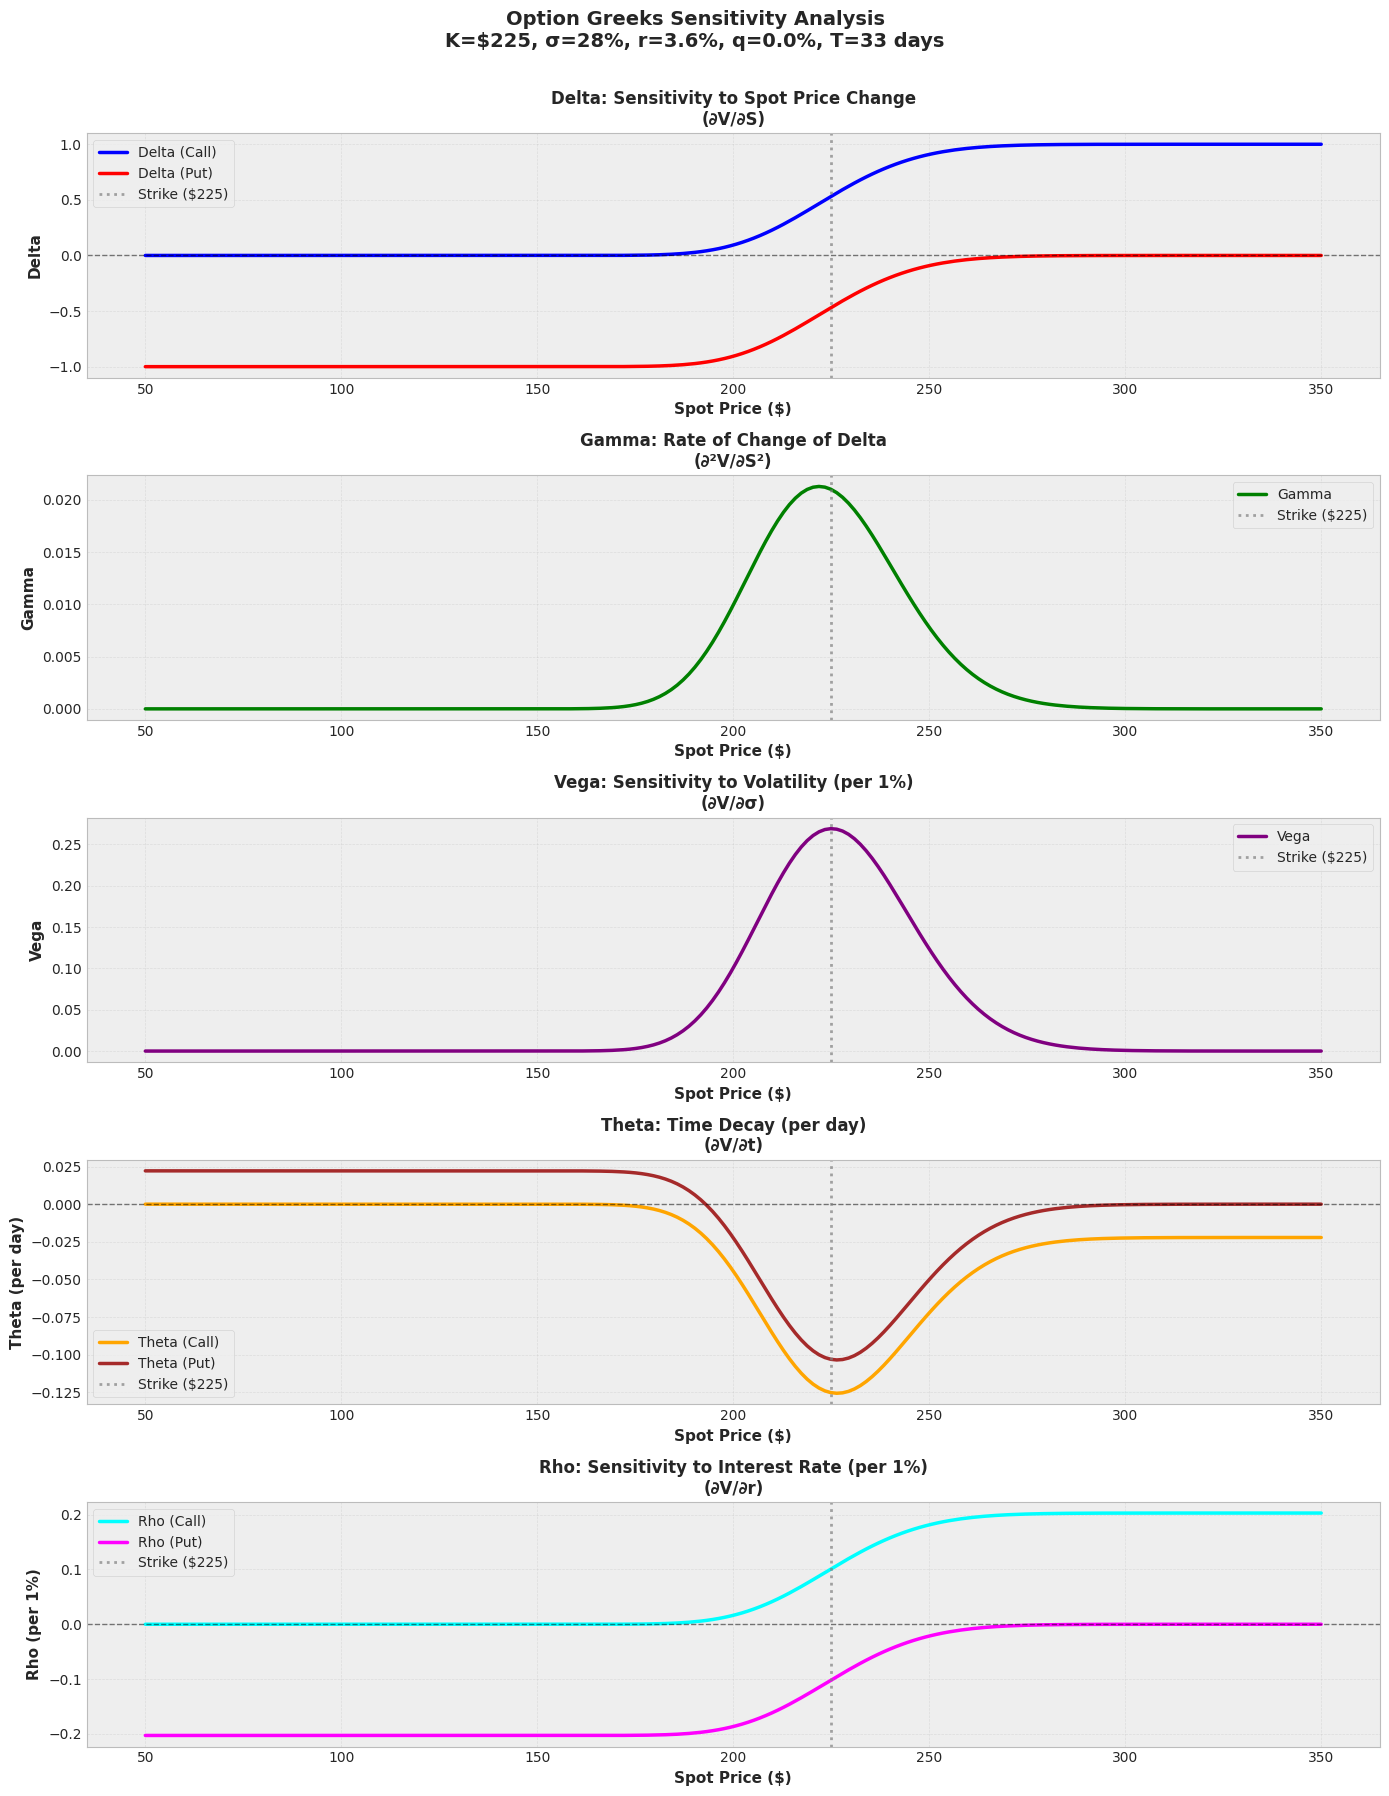

In [6]:
# Generate Greeks sensitivity plot

S_range = np.linspace(50, 350, 200)
plot_greeks_vs_spot(
    S_range=S_range,
    K=X_test,
    sigma=sigma_test,
    r=r_test,
    q=q_test,
    t=t_test,
    save_path='greeks_sensitivity_analysis.png'
)


### 4.2 Greeks Heatmaps (2D Sensitivity Analysis)

In [7]:
def plot_greeks_heatmaps(
    S_range: np.ndarray,
    sigma_range: np.ndarray,
    K: float,
    r: float,
    q: float,
    t: int,
    save_path: Optional[str] = None
) -> None:
    """
    Create heatmaps showing Greeks sensitivity to spot price and volatility.
    """
    plt.close('all')
    
    # Create meshgrid
    S_grid, sigma_grid = np.meshgrid(S_range, sigma_range)
    
    # Initialize arrays for Greeks
    delta_call_grid = np.zeros_like(S_grid)
    gamma_grid = np.zeros_like(S_grid)
    vega_grid = np.zeros_like(S_grid)
    theta_call_grid = np.zeros_like(S_grid)
    
    # Calculate Greeks for each combination
    for i in range(len(sigma_range)):
        for j in range(len(S_range)):
            greeks = bsm_greeks(S_grid[i, j], K, sigma_grid[i, j], r, q, t)
            delta_call_grid[i, j] = greeks['Delta (Call)']
            gamma_grid[i, j] = greeks['Gamma']
            vega_grid[i, j] = greeks['Vega']
            theta_call_grid[i, j] = greeks['Theta (Call)']
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Delta heatmap
    im1 = axes[0, 0].contourf(S_grid, sigma_grid*100, delta_call_grid, 
                               levels=20, cmap='RdYlGn')
    axes[0, 0].axvline(K, color='white', linestyle='--', linewidth=2, label=f'Strike (${K})')
    axes[0, 0].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Volatility (%)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Delta (Call)', fontsize=12, fontweight='bold')
    fig.colorbar(im1, ax=axes[0, 0])
    
    # Gamma heatmap
    im2 = axes[0, 1].contourf(S_grid, sigma_grid*100, gamma_grid, 
                               levels=20, cmap='viridis')
    axes[0, 1].axvline(K, color='white', linestyle='--', linewidth=2, label=f'Strike (${K})')
    axes[0, 1].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Volatility (%)', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Gamma', fontsize=12, fontweight='bold')
    fig.colorbar(im2, ax=axes[0, 1])
    
    # Vega heatmap
    im3 = axes[1, 0].contourf(S_grid, sigma_grid*100, vega_grid, 
                               levels=20, cmap='plasma')
    axes[1, 0].axvline(K, color='white', linestyle='--', linewidth=2, label=f'Strike (${K})')
    axes[1, 0].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Volatility (%)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Vega', fontsize=12, fontweight='bold')
    fig.colorbar(im3, ax=axes[1, 0])
    
    # Theta heatmap
    im4 = axes[1, 1].contourf(S_grid, sigma_grid*100, theta_call_grid, 
                               levels=20, cmap='coolwarm')
    axes[1, 1].axvline(K, color='white', linestyle='--', linewidth=2, label=f'Strike (${K})')
    axes[1, 1].set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Volatility (%)', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Theta (Call)', fontsize=12, fontweight='bold')
    fig.colorbar(im4, ax=axes[1, 1])
    
    # Overall title
    fig.suptitle(f'Greeks Sensitivity Heatmaps: Spot Price vs Volatility\n'
                 f'K=${K}, r={r*100:.1f}%, q={q*100:.1f}%, T={t} days',
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

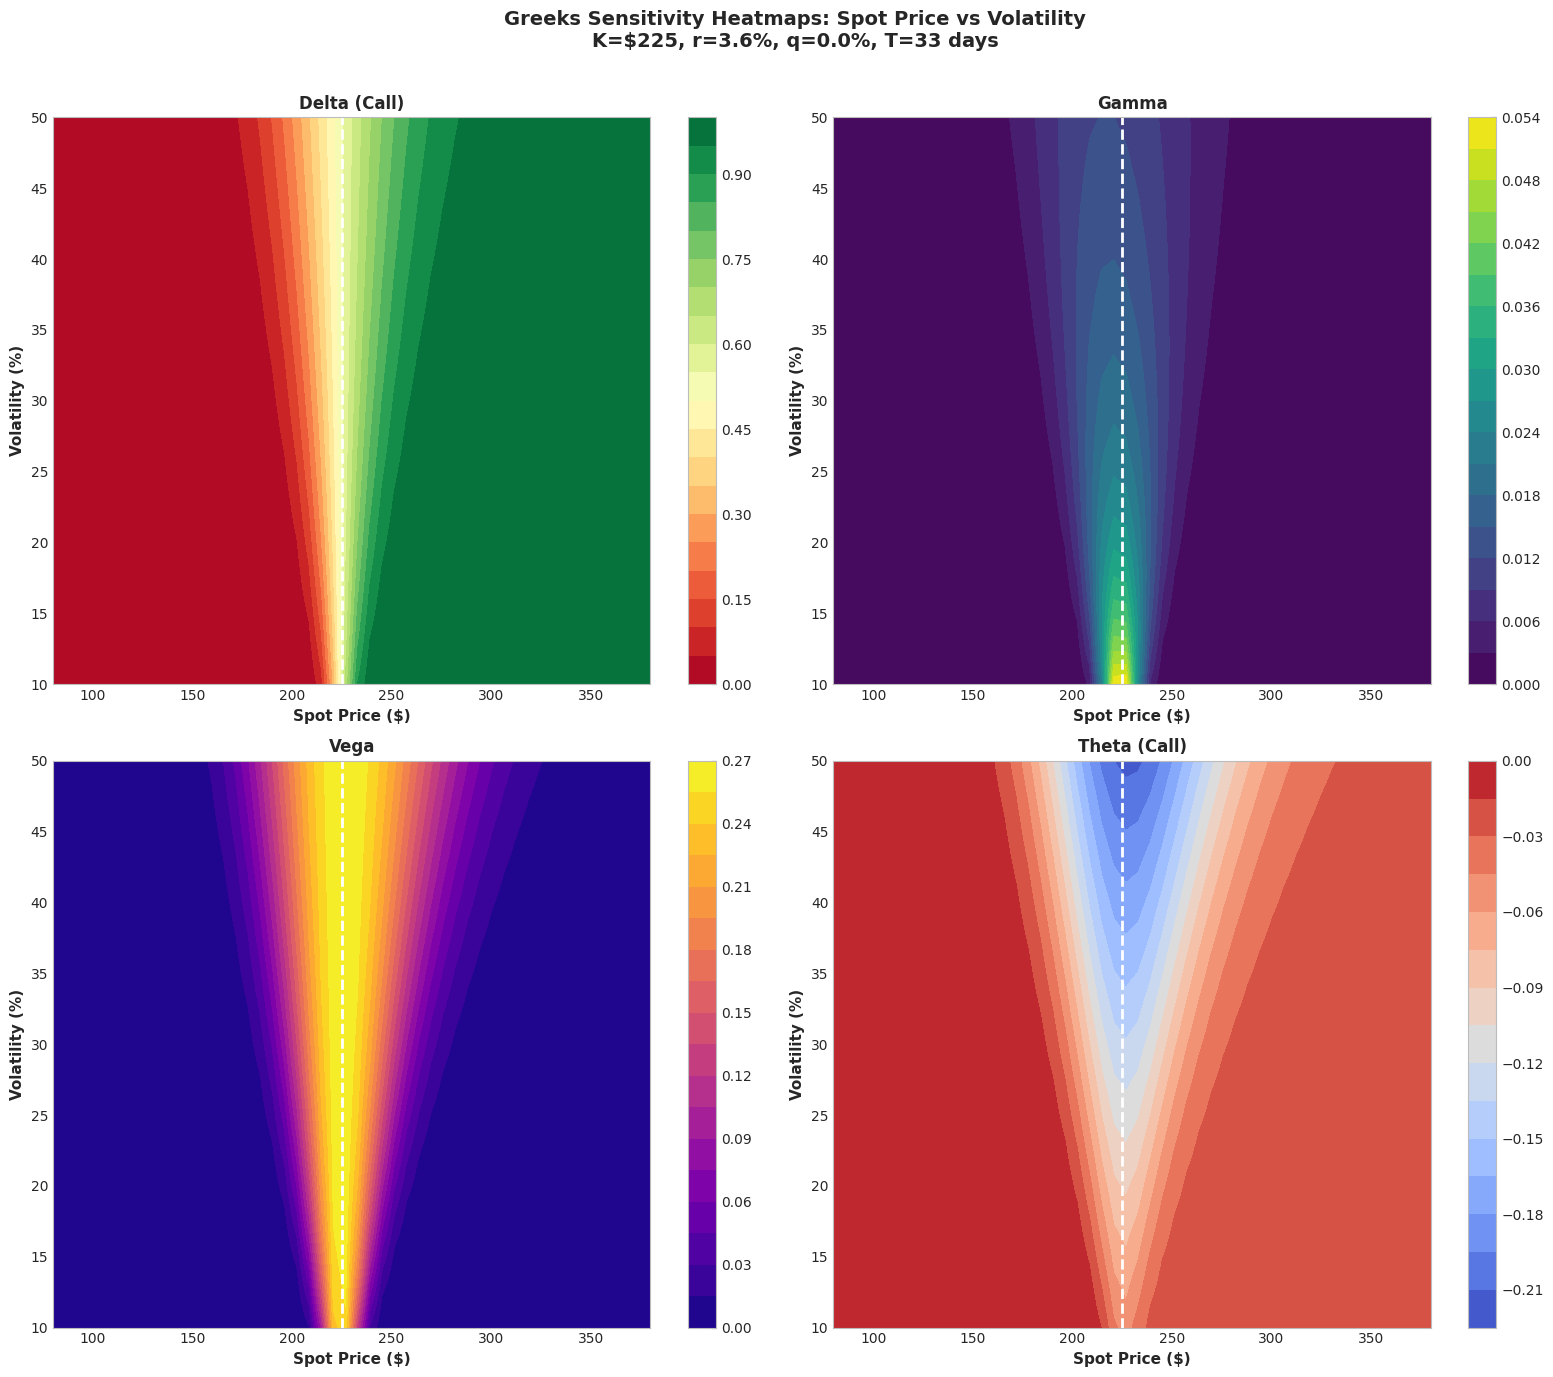

In [8]:
# Generate heatmaps

S_range_heatmap = np.linspace(80, 380, 50)
sigma_range_heatmap = np.linspace(0.10, 0.50, 50)

plot_greeks_heatmaps(
    S_range=S_range_heatmap,
    sigma_range=sigma_range_heatmap,
    K=X_test,
    r=r_test,
    q=q_test,
    t=t_test,
    save_path='greeks_heatmaps.png'
)


### 4.3 3D Surface Plots for Greeks

In [9]:
def plot_greeks_3d_surface(
    S_range: np.ndarray,
    T_range: np.ndarray,
    K: float,
    sigma: float,
    r: float,
    q: float,
    greek_name: str = 'Delta (Call)',
    save_path: Optional[str] = None
) -> None:
    """
    Create 3D surface plot for a specific Greek vs spot price and time to maturity.
    """
    plt.close('all')
    
    # Create meshgrid
    S_grid, T_grid = np.meshgrid(S_range, T_range)
    
    # Initialize array for the Greek
    greek_grid = np.zeros_like(S_grid)
    
    # Calculate Greek for each combination
    for i in range(len(T_range)):
        for j in range(len(S_range)):
            greeks = bsm_greeks(S_grid[i, j], K, sigma, r, q, int(T_grid[i, j]))
            greek_grid[i, j] = greeks[greek_name]
    
    # Create 3D plot
    fig = plt.figure(figsize=(13.7, 7.7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(S_grid, T_grid, greek_grid, 
                           cmap='viridis', alpha=0.9, 
                           edgecolor='none', antialiased=True)
    
    # Labels and title
    ax.set_xlabel('Spot Price ($)', fontsize=11, fontweight='bold', labelpad=10)
    ax.set_ylabel('Time to Maturity (days)', fontsize=11, fontweight='bold', labelpad=10)
    ax.set_zlabel(greek_name, fontsize=11, fontweight='bold', labelpad=10)
    ax.set_title(f'3D Surface: {greek_name}\n'
                 f'K=${K}, σ={sigma*100:.0f}%, r={r*100:.1f}%, q={q*100:.1f}%',
                 fontsize=13, fontweight='bold', pad=20)
    
    # Colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    # Viewing angle
    ax.view_init(elev=25, azim=45)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

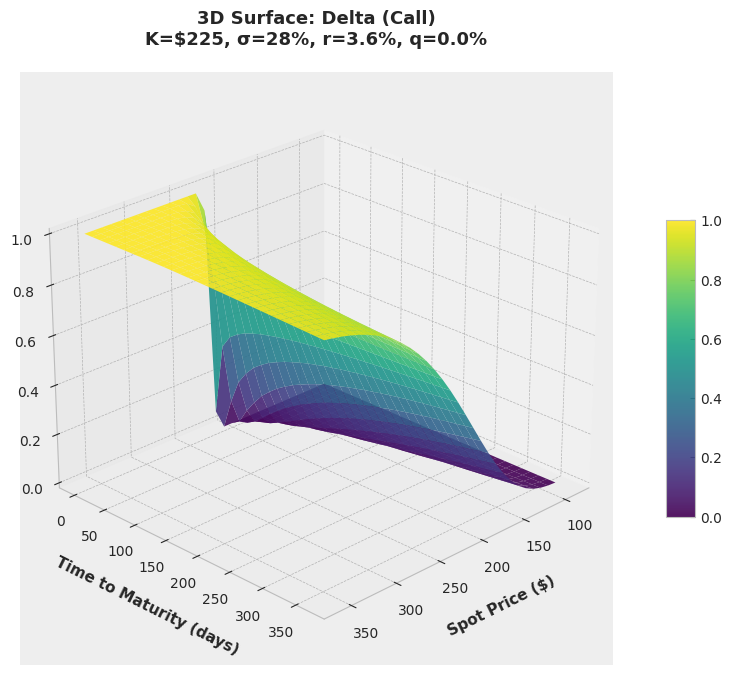

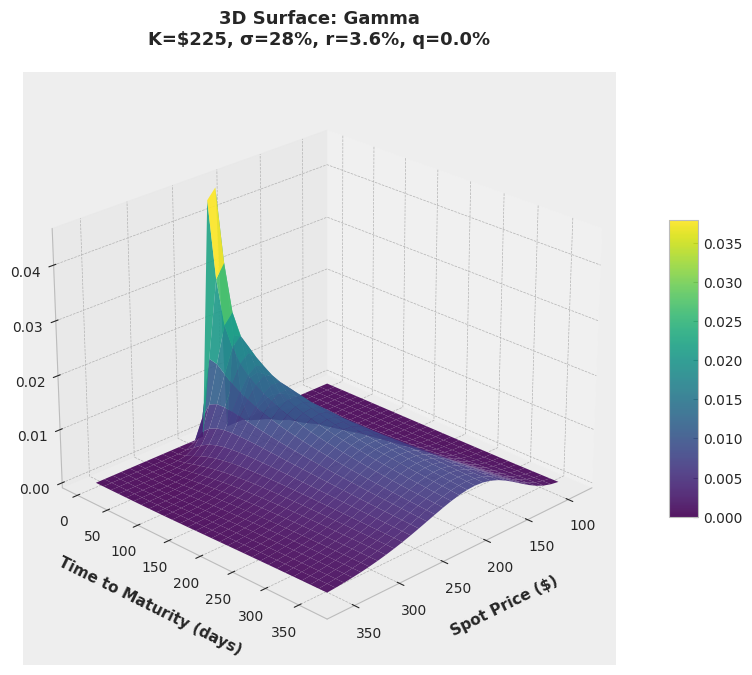

In [10]:
# Generate 3D surface plots for key Greeks

S_range_3d = np.linspace(90, 360, 30)
T_range_3d = np.linspace(1, 365, 30)

# Delta surface
plot_greeks_3d_surface(
    S_range=S_range_3d,
    T_range=T_range_3d,
    K=X_test,
    sigma=sigma_test,
    r=r_test,
    q=q_test,
    greek_name='Delta (Call)',
    save_path='delta_3d_surface.png'
)

# Gamma surface
plot_greeks_3d_surface(
    S_range=S_range_3d,
    T_range=T_range_3d,
    K=X_test,
    sigma=sigma_test,
    r=r_test,
    q=q_test,
    greek_name='Gamma',
    save_path='gamma_3d_surface.png'
)


## 5. Greeks Dashboard for Multiple Strikes

In [11]:
def create_greeks_dashboard(
    S: float,
    K_range: List[float],
    sigma: float,
    r: float,
    q: float,
    t: int
) -> pd.DataFrame:
    """
    Create a comprehensive dashboard of Greeks for multiple strike prices.
    """
    dashboard_data = []
    
    for K in K_range:
        # Calculate option prices
        call_price = black_scholes_call(S, K, r, sigma, t/365, q=q)
        put_price = black_scholes_put(S, K, r, sigma, t/365, q=q)
        
        # Calculate Greeks
        greeks = bsm_greeks(S, K, sigma, r, q, t)
        
        # Moneyness
        moneyness = S / K
        if moneyness > 1.02:
            status = 'ITM'
        elif moneyness < 0.98:
            status = 'OTM'
        else:
            status = 'ATM'
        
        dashboard_data.append({
            'Strike': K,
            'Moneyness': moneyness,
            'Status': status,
            'Call Price': call_price,
            'Put Price': put_price,
            'Delta (Call)': greeks['Delta (Call)'],
            'Delta (Put)': greeks['Delta (Put)'],
            'Gamma': greeks['Gamma'],
            'Vega': greeks['Vega'],
            'Theta (Call)': greeks['Theta (Call)'],
            'Theta (Put)': greeks['Theta (Put)'],
            'Rho (Call)': greeks['Rho (Call)'],
            'Rho (Put)': greeks['Rho (Put)']
        })
    
    df = pd.DataFrame(dashboard_data)
    return df

In [12]:
# Create Greeks dashboard
print("\n" + "=" * 120)
print("GREEKS DASHBOARD FOR MULTIPLE STRIKES")
print("=" * 120)

K_range_dashboard = [170, 195, 205, 215, 225, 255, 280, 295]

dashboard = create_greeks_dashboard(
    S=S_test,
    K_range=K_range_dashboard,
    sigma=sigma_test,
    r=r_test,
    q=q_test,
    t=t_test
)

print(f"\nSpot Price: ${S_test}")
print(f"Volatility: {sigma_test * 100:.1f}%")
print(f"Risk-Free Rate: {r_test * 100:.1f}%")
print(f"Time to Maturity: {t_test} days\n")

print(dashboard.to_string(index=False, float_format=lambda x: f'{x:.6f}'))
print("=" * 120)


GREEKS DASHBOARD FOR MULTIPLE STRIKES

Spot Price: $214
Volatility: 28.0%
Risk-Free Rate: 3.6%
Time to Maturity: 33 days

 Strike  Moneyness Status  Call Price  Put Price  Delta (Call)  Delta (Put)    Gamma     Vega  Theta (Call)  Theta (Put)  Rho (Call)  Rho (Put)
    170   1.258824    ITM   44.565777   0.013362      0.997559    -0.002441 0.000422 0.004887     -0.018733    -0.002020    0.152715  -0.000484
    195   1.097436    ITM   20.714486   1.080833      0.882011    -0.117989 0.010971 0.127192     -0.070534    -0.051363    0.151923  -0.023806
    205   1.043902    ITM   12.888172   3.222024      0.722771    -0.277229 0.018593 0.215559     -0.105433    -0.085280    0.128189  -0.056551
    215   0.995349    ATM    7.041003   7.342360      0.510125    -0.489875 0.022135 0.256622     -0.118943    -0.097806    0.092333  -0.101419
    225   0.951111    OTM    3.334308  13.603170      0.303414    -0.696586 0.019396 0.224869     -0.101474    -0.079355    0.055690  -0.147074
    255   0.8

## 6. Monte Carlo Simulation with Greeks

In [13]:
def simulate_stock_paths(
    S0: float,
    r: float,
    sigma: float,
    T: float,
    n_steps: int,
    n_paths: int,
    q: float = 0.0,
    random_seed: Optional[int] = None
) -> np.ndarray:
    """
    Simulate stock price paths using geometric Brownian motion.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    dt = T / n_steps
    
    # Pre-allocate array
    S = np.zeros((n_steps + 1, n_paths))
    S[0, :] = S0
    
    # Generate all random numbers at once
    Z = np.random.standard_normal((n_steps, n_paths))
    
    # Simulate paths
    drift = (r - q - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    for t in range(1, n_steps + 1):
        S[t, :] = S[t-1, :] * np.exp(drift + diffusion * Z[t-1, :])
    
    return S


def monte_carlo_option_price(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    option_type: str = 'call',
    n_simulations: int = 100000,
    q: float = 0.0,
    random_seed: Optional[int] = None
) -> Tuple[float, float]:
    """
    Price European option using Monte Carlo simulation.
    
    Returns:
    --------
    tuple
        (option_price, standard_error)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Generate random standard normal variables
    Z = np.random.standard_normal(n_simulations)
    
    # Simulate terminal stock prices
    ST = S * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:  # put
        payoffs = np.maximum(K - ST, 0)
    
    # Discount back to present value
    discount_factor = np.exp(-r * T)
    option_price = discount_factor * np.mean(payoffs)
    standard_error = discount_factor * np.std(payoffs, ddof=1) / np.sqrt(n_simulations)
    
    return option_price, standard_error

In [14]:
print("\n" + "=" * 80)
print("MONTE CARLO vs ANALYTICAL COMPARISON")
print("=" * 80)

# Parameters
S_mc = S_test
K_mc = X_test
T_mc = t_test / 365

# Analytical
call_analytical = black_scholes_call(S_mc, K_mc, r_test, sigma_test, T_mc, q=q_test)
put_analytical = black_scholes_put(S_mc, K_mc, r_test, sigma_test, T_mc, q=q_test)
greeks_analytical = bsm_greeks(S_mc, K_mc, sigma_test, r_test, q_test, t_test)

# Monte Carlo
call_mc, call_se = monte_carlo_option_price(
    S_mc, K_mc, r_test, sigma_test, T_mc,
    option_type='call', n_simulations=100000, q=q_test, random_seed=RANDOM_SEED
)
put_mc, put_se = monte_carlo_option_price(
    S_mc, K_mc, r_test, sigma_test, T_mc,
    option_type='put', n_simulations=100000, q=q_test, random_seed=RANDOM_SEED
)

print(f"\nOption Prices:")
print(f"  {'Method':<20} {'Call Price':>15} {'Put Price':>15}")
print(f"  {'-' * 20} {'-' * 15} {'-' * 15}")
print(f"  {'Analytical':<20} ${call_analytical:>14.6f} ${put_analytical:>14.6f}")
print(f"  {'Monte Carlo':<20} ${call_mc:>14.6f} ${put_mc:>14.6f}")
print(f"  {'MC Std Error':<20}  ±${call_se:>13.6f}  ±${put_se:>13.6f}")
print(f"  {'Absolute Error':<20} ${abs(call_mc-call_analytical):>14.6f} ${abs(put_mc-put_analytical):>14.6f}")
print(f"  {'Relative Error (%)':<20} {100*abs(call_mc-call_analytical)/call_analytical:>14.4f} {100*abs(put_mc-put_analytical)/put_analytical:>14.4f}")

print(f"\nAnalytical Greeks:")
print(f"  {'Greek':<20} {'Value':>15}")
print(f"  {'-' * 20} {'-' * 15}")
for greek_name, greek_value in greeks_analytical.items():
    print(f"  {greek_name:<20} {greek_value:>15.6f}")

print("=" * 80)


MONTE CARLO vs ANALYTICAL COMPARISON

Option Prices:
  Method                    Call Price       Put Price
  -------------------- --------------- ---------------
  Analytical           $      3.334308 $     13.603170
  Monte Carlo          $      3.357330 $     13.570054
  MC Std Error          ±$     0.024402  ±$     0.041959
  Absolute Error       $      0.023021 $      0.033116
  Relative Error (%)           0.6904         0.2434

Analytical Greeks:
  Greek                          Value
  -------------------- ---------------
  Delta (Call)                0.303414
  Delta (Put)                -0.696586
  Gamma                       0.019396
  Vega                        0.224869
  Theta (Call)               -0.101474
  Theta (Put)                -0.079355
  Rho (Call)                  0.055690
  Rho (Put)                  -0.147074


## 7. Real Market Data Analysis with Greeks

In [15]:
@lru_cache(maxsize=32)
def fetch_ticker_data(symbol: str) -> yf.Ticker:
    """Fetch ticker data with caching."""
    try:
        ticker = yf.Ticker(symbol)
        _ = ticker.history(period='1d')
        return ticker
    except Exception as e:
        raise ValueError(f"Failed to fetch data for {symbol}: {str(e)}")


def get_current_price(ticker: yf.Ticker) -> float:
    """Get current stock price."""
    try:
        hist = ticker.history(period='5d')
        if hist.empty:
            raise ValueError("No price data available")
        return hist['Close'].iloc[-1]
    except Exception as e:
        raise ValueError(f"Failed to get current price: {str(e)}")


def calculate_time_to_maturity(expiration_date_str: str) -> float:
    """Calculate time to maturity in years."""
    expiration_date = datetime.strptime(expiration_date_str, "%Y-%m-%d")
    today = datetime.now()
    days_to_maturity = (expiration_date - today).days
    return max(days_to_maturity, 0) / 365.0


def get_risk_free_rate(days_to_maturity: int) -> float:
    """Get risk-free rate based on time to maturity."""
    yield_curve = {
        30: 3.620, 60: 3.645, 90: 3.612, 120: 3.634, 180: 3.606,
        365: 3.514, 730: 3.485, 1095: 3.529, 1825: 3.695, 2555: 3.907,
        3650: 4.151, 7300: 4.785, 10950: 4.828
    }
    
    sorted_maturities = sorted(yield_curve.keys())
    
    if days_to_maturity <= 0:
        return yield_curve[sorted_maturities[0]] / 100
    elif days_to_maturity >= sorted_maturities[-1]:
        return yield_curve[sorted_maturities[-1]] / 100
    else:
        for maturity in sorted_maturities:
            if days_to_maturity <= maturity:
                return yield_curve[maturity] / 100
    
    return yield_curve[sorted_maturities[-1]] / 100

In [16]:
# Fetch market data for analysis
TICKER_SYMBOL = 'BA'  # Boeing

try:
    print(f"\n{'=' * 80}")
    print(f"FETCHING MARKET DATA FOR {TICKER_SYMBOL}")
    print(f"{'=' * 80}")
    
    ticker = fetch_ticker_data(TICKER_SYMBOL)
    current_price = get_current_price(ticker)
    expirations = ticker.options
    
    print(f" Current price: ${current_price:.2f}")
    print(f" Available expirations: {len(expirations)}")
    
    if len(expirations) > 0:
        exp_date = expirations[0]
        opt_chain = ticker.option_chain(exp_date)
        calls = opt_chain.calls
        
        tau = calculate_time_to_maturity(exp_date)
        days_to_mat = int(tau * 365)
        rf_rate = get_risk_free_rate(days_to_mat)
        
        print(f" Analyzing expiration: {exp_date}")
        print(f"  Time to maturity: {tau:.4f} years ({days_to_mat} days)")
        print(f"  Risk-free rate: {rf_rate*100:.3f}%")
        print(f"  Number of strikes: {len(calls)}")
        
        # Calculate Greeks for market options
        market_greeks_data = []
        
        for idx, row in calls.iterrows():
            K = row['strike']
            market_price = row['lastPrice']
            impl_vol = row['impliedVolatility']
            
            if impl_vol > 0 and not pd.isna(impl_vol):
                # Calculate theoretical Greeks
                greeks = bsm_greeks(current_price, K, impl_vol, rf_rate, 0.0, days_to_mat)
                
                # Calculate theoretical price
                theo_price = black_scholes_call(current_price, K, rf_rate, impl_vol, tau, q=0.0)
                
                market_greeks_data.append({
                    'Strike': K,
                    'Market Price': market_price,
                    'Theo Price': theo_price,
                    'Impl Vol (%)': impl_vol * 100,
                    'Delta': greeks['Delta (Call)'],
                    'Gamma': greeks['Gamma'],
                    'Vega': greeks['Vega'],
                    'Theta': greeks['Theta (Call)'],
                    'Rho': greeks['Rho (Call)']
                })
        
        df_market_greeks = pd.DataFrame(market_greeks_data)
        
        print(f"\n{'=' * 120}")
        print(f"MARKET OPTIONS GREEKS ANALYSIS - {TICKER_SYMBOL}")
        print(f"Expiration: {exp_date} | Spot: ${current_price:.2f} | Days: {days_to_mat}")
        print(f"{'=' * 120}")
        print(df_market_greeks.head(10).to_string(index=False, float_format=lambda x: f'{x:.6f}'))
        print(f"{'=' * 120}")
    else:
        print(" No expiration dates available")

except Exception as e:
    print(f"Error fetching market data: {str(e)}")
    print("Continuing with theoretical analysis...")


FETCHING MARKET DATA FOR BA
 Current price: $214.08
 Available expirations: 18
 Analyzing expiration: 2025-12-26
  Time to maturity: 0.0110 years (4 days)
  Risk-free rate: 3.620%
  Number of strikes: 33

MARKET OPTIONS GREEKS ANALYSIS - BA
Expiration: 2025-12-26 | Spot: $214.08 | Days: 4
    Strike  Market Price  Theo Price  Impl Vol (%)    Delta    Gamma     Vega     Theta      Rho
150.000000     58.170000   64.311766    158.984580 0.986888 0.000947 0.007558 -0.164772 0.016105
170.000000     44.100000   44.520460    124.072645 0.967338 0.002625 0.016359 -0.269842 0.017816
175.000000     40.020000   39.449713    106.592264 0.968959 0.002930 0.015686 -0.225661 0.018409
180.000000     34.900000   34.487641     96.044961 0.962360 0.003810 0.018379 -0.237663 0.018798
182.500000     22.960000   31.652387      0.001000 1.000000 0.000000 0.000000 -0.018093 0.019992
185.000000     30.570000   29.249565     67.285483 0.982722 0.002835 0.009580 -0.098541 0.019850
187.500000     27.460000   26.

## 8. Greeks Risk Management Applications

In [17]:
def calculate_portfolio_greeks(
    positions: List[Dict],
    S: float,
    r: float,
    q: float = 0.0
) -> Dict[str, float]:
    """
    Calculate aggregate Greeks for an options portfolio.
    """
    portfolio_greeks = {
        'Delta': 0.0,
        'Gamma': 0.0,
        'Vega': 0.0,
        'Theta': 0.0,
        'Rho': 0.0
    }
    
    for position in positions:
        K = position['K']
        sigma = position['sigma']
        t = position['T']
        quantity = position['quantity']
        opt_type = position['type'].lower()
        
        greeks = bsm_greeks(S, K, sigma, r, q, t)
        
        if opt_type == 'call':
            portfolio_greeks['Delta'] += quantity * greeks['Delta (Call)']
            portfolio_greeks['Theta'] += quantity * greeks['Theta (Call)']
            portfolio_greeks['Rho'] += quantity * greeks['Rho (Call)']
        else:  # put
            portfolio_greeks['Delta'] += quantity * greeks['Delta (Put)']
            portfolio_greeks['Theta'] += quantity * greeks['Theta (Put)']
            portfolio_greeks['Rho'] += quantity * greeks['Rho (Put)']
        
        # Gamma and Vega are the same for calls and puts
        portfolio_greeks['Gamma'] += quantity * greeks['Gamma']
        portfolio_greeks['Vega'] += quantity * greeks['Vega']
    
    return portfolio_greeks

In [18]:
# Example portfolio
print("\n" + "=" * 80)
print("PORTFOLIO GREEKS ANALYSIS")
print("=" * 80)

portfolio_positions = [
    {'type': 'call', 'K': 200, 'sigma': 0.28, 'T': 182, 'quantity': 10},
    {'type': 'call', 'K': 220, 'sigma': 0.28, 'T': 182, 'quantity': -5},
    {'type': 'put', 'K': 180, 'sigma': 0.28, 'T': 182, 'quantity': 5},
]

portfolio_greeks = calculate_portfolio_greeks(
    positions=portfolio_positions,
    S=S_test,
    r=r_test,
    q=q_test
)

print(f"\nPortfolio Composition:")
for i, pos in enumerate(portfolio_positions, 1):
    print(f"  Position {i}: {pos['quantity']:+4d} x {pos['type'].upper():4s} "
          f"K=${pos['K']}, σ={pos['sigma']*100:.0f}%, T={pos['T']} days")

print(f"\nSpot Price: ${S_test}")

print(f"\nAggregate Portfolio Greeks:")
print(f"  {'Greek':<15} {'Value':>15}  {'Interpretation'}")
print(f"  {'-' * 15} {'-' * 15}  {'-' * 50}")
print(f"  {'Delta':<15} {portfolio_greeks['Delta']:>15.4f}  "
      f"Portfolio moves ${abs(portfolio_greeks['Delta']):.2f} for $1 move in underlying")
print(f"  {'Gamma':<15} {portfolio_greeks['Gamma']:>15.6f}  "
      f"Delta changes by {portfolio_greeks['Gamma']:.6f} for $1 move")
print(f"  {'Vega':<15} {portfolio_greeks['Vega']:>15.4f}  "
      f"Portfolio moves ${abs(portfolio_greeks['Vega']):.2f} for 1% vol change")
print(f"  {'Theta':<15} {portfolio_greeks['Theta']:>15.4f}  "
      f"Portfolio loses ${abs(portfolio_greeks['Theta']):.2f} per day (time decay)")
print(f"  {'Rho':<15} {portfolio_greeks['Rho']:>15.4f}  "
      f"Portfolio moves ${abs(portfolio_greeks['Rho']):.2f} for 1% rate change")

print("=" * 80)


PORTFOLIO GREEKS ANALYSIS

Portfolio Composition:
  Position 1:  +10 x CALL K=$200, σ=28%, T=182 days
  Position 2:   -5 x CALL K=$220, σ=28%, T=182 days
  Position 3:   +5 x PUT  K=$180, σ=28%, T=182 days

Spot Price: $214

Aggregate Portfolio Greeks:
  Greek                     Value  Interpretation
  --------------- ---------------  --------------------------------------------------
  Delta                    3.7090  Portfolio moves $3.71 for $1 move in underlying
  Gamma                  0.061512  Delta changes by 0.061512 for $1 move
  Vega                     3.9330  Portfolio moves $3.93 for 1% vol change
  Theta                   -0.3609  Portfolio loses $0.36 per day (time decay)
  Rho                      2.9519  Portfolio moves $2.95 for 1% rate change


## References

1. **Global Association of Risk Professionals (2025).**  
   *FRM Part 1 Book 4: Valuation and Risk Models*, Chapter 15: The Black-Scholes-Merton Model, pp. 202-215.

2. **Global Association of Risk Professionals (2025).**  
   *FRM Part 1 Book 4: Valuation and Risk Models*, Chapter 16: Option Sensitivity Measures: The "Greeks", pp. 216-231.
   
3. Risk-free interest rate.  (December 20, 2025). https://www.investing.com/rates-bonds/usa-government-bonds

Github references:

- https://github.com/dreamchef/Black-Scholes-options-pricing/tree/main
- https://github.com/aldodec/Black-Scholes-Option-Pricing-with-Monte-Carlo-
- https://github.com/mauedu93/Black-Scholes-Model